# Quantum Simulation of a Wave Function Passing Through Multiple Square Potentials

In this notebook, we will simulate a quantum wave function passing through multiple square potential wells, similar to navigating a "Mario game level" where each bin has a different height of potential. We aim to maximize the probability of detecting the wave function after it has traversed all potential bins. Specifically, we will optimize the last three potential values to achieve the highest detection probability.

**Key Objectives:**
- Set up a quantum circuit to simulate the wave function evolution.
- Represent each square potential with quantum gates.
- Optimize the last three potentials to maximize the detection probability.
- Visualize the evolution and results.


## Step 1: Set Up the Quantum Device

We will use PennyLane to set up our quantum circuit. For this simulation, we'll start with a single qubit to represent the wave function. Each "bin" or potential well will correspond to a quantum operation that modifies the state of the qubit.


In [1]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Define the number of qubits (could represent different potential regions)
n_qubits = 2  # define number of qubits you like here
n_bins = 10   # Number of potential wells

## Impact of Adding More Qubits to the Wave Function

When we start with just **one qubit**, the quantum system is simpler to understand and simulate. The wave function of a single qubit can be represented as a superposition of just two basis states:

$$
|\psi\rangle = \alpha|0\rangle + \beta|1\rangle
$$

where \( \alpha \) and \( \beta \) are complex amplitudes that must satisfy the normalization condition \( |\alpha|^2 + |\beta|^2 = 1 \).

### What Happens When We Add More Qubits?

1. **Expansion of the State Space**:
   - For **two qubits**, the wave function becomes a superposition of four basis states:

   $$
   |\psi\rangle = \alpha_{00}|00\rangle + \alpha_{01}|01\rangle + \alpha_{10}|10\rangle + \alpha_{11}|11\rangle
   $$

   The number of basis states grows exponentially with the number of qubits. For \( n \) qubits, the wave function is a superposition of \( 2^n \) basis states:

   $$
   |\psi\rangle = \sum_{i=0}^{2^n - 1} \alpha_i |i\rangle
   $$

   This exponential growth makes the system more complex and difficult to simulate as more qubits are added.

2. **Increased Complexity and Quantum Entanglement**:
   - With more qubits, the wave function can represent more complex superpositions and entangled states, where the state of one qubit is dependent on the state of another. This entanglement introduces correlations that have no classical counterpart, adding to the system's complexity.

3. **More Complex Quantum Interference**:
   - More qubits allow for more intricate interference patterns, where different quantum "paths" interfere constructively or destructively. This capability is critical for quantum algorithms but makes the system harder to analyze and predict.

4. **Implications for Potential Wells Simulation**:
   - Adding more qubits allows you to model more sophisticated potential landscapes. Each qubit could represent different dimensions or aspects of the wave function's path through these potential wells.
   - This added complexity could be useful for simulating systems with multi-dimensional potentials or interactions between multiple particles, but it also increases the difficulty of both simulation and analysis.

5. **Impact on Measurement and Optimization**:
   - With one qubit, a measurement collapses the wave function to either \( |0\rangle \) or \( |1\rangle \). With more qubits, there are \( 2^n \) possible measurement outcomes, complicating the interpretation of results.
   - Optimizing the parameters of your potential wells becomes more challenging as the number of qubits increases. The optimizer must account for how changes to one qubit's potential affect the entire entangled state of the system.


Starting with one qubit simplifies both the theoretical analysis and the practical simulation of quantum systems. As more qubits are added, the wave function's state space expands exponentially, allowing for richer quantum behaviors such as entanglement and interference. However, this also significantly increases the system's complexity, making it more challenging to simulate, optimize, and understand.

By understanding these complexities, we can better appreciate the power and challenges of quantum computing as we scale up from simple to more sophisticated quantum systems.


In [3]:
# Initialize the quantum device
dev = qml.device('default.qubit', wires=n_qubits)

# Define the quantum circuit
@qml.qnode(dev)
def quantum_circuit(params):
    """
    Quantum circuit simulating a wave function passing through multiple square potential wells.
    
    Args:
        params (array[float]): An array of parameters representing the "heights" of the square potentials.
    
    Returns:
        array[float]: An array of probabilities representing the likelihood of the wave function 
                      being detected in each basis state after passing through the potentials.
    """
    
    # Initialize the state to |0>
    qml.BasisState(np.array([0]), wires=0)

    # Apply operations representing square potentials
    for i in range(n_bins):
        qml.RX(params[i], wires=0)  # Rotation around X-axis representing the potential's effect
        qml.RY(params[i], wires=0)  # adding complexity with Y rotation

    # Measure the probability of being in state |0>
    return qml.probs(wires=0)

## Step 2: Visualize the Wave Function Evolution

To understand how the wave function evolves as it passes through each potential, we will visualize the probability distribution at each step. Each step corresponds to passing through a potential well represented by a quantum gate.


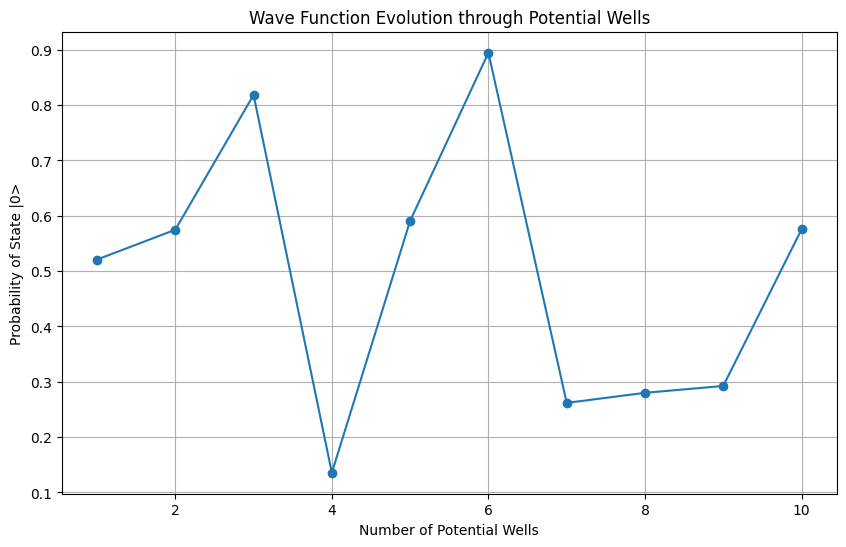

In [4]:
# Initial parameters for the potentials (randomly initialized)
init_params = np.random.uniform(0, np.pi, n_bins)

def visualize_wave_evolution(params, n_bins, circuit):
    """
    Visualizes the evolution of the wave function through the potential wells.
    
    Args:
        params (array[float]): An array of initial parameters representing the "heights" of the square potentials.
        n_bins (int): Number of potential wells.
        circuit (function): The quantum circuit function that simulates the wave function passing through potentials.
    
    Returns:
        list[float]: List of probabilities of the wave function being in state |0> at each step.
    """
    probabilities = []
    for i in range(n_bins):
        partial_params = np.pad(params[:i+1], (0, n_bins-i-1))
        probs = circuit(partial_params)
        probabilities.append(probs[0])

    # Plot the evolution
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, n_bins+1), probabilities, marker='o')
    plt.xlabel('Number of Potential Wells')
    plt.ylabel('Probability of State |0>')
    plt.title('Wave Function Evolution through Potential Wells')
    plt.grid(True)
    plt.show()

    return probabilities

# Visualize the initial wave function evolution and store probabilities
probabilities = visualize_wave_evolution(init_params, n_bins, quantum_circuit)


## Step 3: Define the Cost Function for Optimization

Our goal is to maximize the probability of detecting the wave function in the state |0> after passing through all potential wells. We define a cost function that returns the negative of this probability to use with a gradient-based optimizer.


In [5]:
# Define the cost function to maximize the probability of the wave function being in state |0>
def cost_last_three(params_last_three, fixed_params):
    """
    Computes the cost function focusing on optimizing the last three potential wells.
    
    Args:
        params_last_three (array[float]): Parameters for the last three potentials.
        fixed_params (array[float]): Fixed parameters for the first seven potentials.
    
    Returns:
        float: The negative probability of the wave function being in state |0>.
    """
    # Combine fixed parameters with the last three that are being optimized
    params = np.concatenate([fixed_params, params_last_three])
    probs = quantum_circuit(params)
    return -probs[0]

# Fixed initial parameters for the first seven potentials
fixed_params = init_params[:7]

# Initial parameters for the last three potentials
init_params_last_three = init_params[7:]

# Optimization loop focusing only on the last three potentials
n_iterations = 100
opt = qml.GradientDescentOptimizer(stepsize=0.1)
params_last_three = init_params_last_three

costs = []

for it in range(n_iterations):
    params_last_three = opt.step(lambda x: cost_last_three(x, fixed_params), params_last_three)
    costs.append(cost_last_three(params_last_three, fixed_params))
    if it % 10 == 0:
        print(f"Iteration {it}: Cost = {cost_last_three(params_last_three, fixed_params)}")

print(f"Optimized parameters for the last three potentials: {params_last_three}")



Iteration 0: Cost = -0.6526628684996785
Iteration 10: Cost = -0.9656541135009898
Iteration 20: Cost = -0.9768608011264025
Iteration 30: Cost = -0.9831103924530336
Iteration 40: Cost = -0.988803676457499
Iteration 50: Cost = -0.9932924269376439
Iteration 60: Cost = -0.9963404081133541
Iteration 70: Cost = -0.9981537746626428
Iteration 80: Cost = -0.9991232837544172
Iteration 90: Cost = -0.9996015965907576
Optimized parameters for the last three potentials: [1.21676527 0.00149137 1.36949523]


## Step 4: Visualize Optimization Results

After the optimization process, we'll visualize the cost function's convergence to see how well our optimization algorithm performed. We'll also compare the initial and optimized probability distributions.


In [6]:
def visualize_cost_convergence(costs):
    """
    Visualizes the convergence of the cost function over the optimization iterations.
    
    Args:
        costs (list[float]): A list of cost values recorded during each iteration of optimization.
    
    Returns:
        None: Displays a plot showing the cost function convergence.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(costs)), costs, marker='o', color='r')
    plt.xlabel('Iteration')
    plt.ylabel('Cost')
    plt.title('Cost Function Convergence')
    plt.grid(True)
    plt.show()

In [10]:
# Update the visualize_optimized_evolution function to use full_params
def visualize_optimized_evolution(params_last_three, n_bins, circuit, initial_probabilities):
    """
    Visualizes the optimized evolution of the wave function through the potential wells.
    
    Args:
        params_last_three (array[float]): Optimized parameters for the last three potentials.
        n_bins (int): Number of potential wells.
        circuit (function): The quantum circuit function that simulates the wave function passing through potentials.
        initial_probabilities (list[float]): Initial probabilities for comparison.
    """
    # Combine fixed initial parameters with optimized last three potentials
    full_params = np.concatenate([fixed_params, params_last_three])
    
    optimized_probabilities = []
    for i in range(n_bins):
        partial_params = np.pad(full_params[:i+1], (0, n_bins-i-1))
        probs = circuit(partial_params)
        optimized_probabilities.append(probs[0])

    # Plot the optimized evolution
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, n_bins+1), optimized_probabilities, marker='o', label='Optimized')
    plt.plot(range(1, n_bins+1), initial_probabilities, marker='x', linestyle='--', label='Initial')
    plt.xlabel('Number of Potential Wells')
    plt.ylabel('Probability of State |0>')
    plt.title('Wave Function Evolution through Potential Wells (Optimized)')
    plt.grid(True)
    plt.legend()
    plt.show()



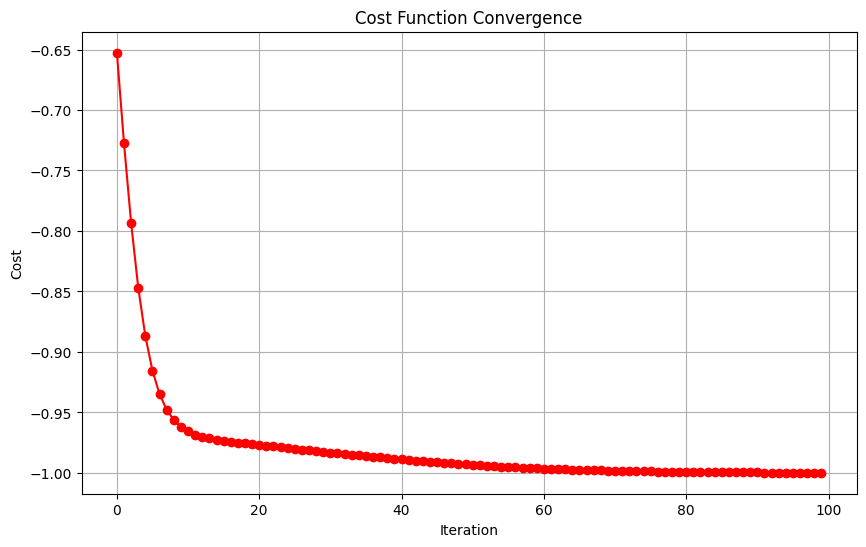

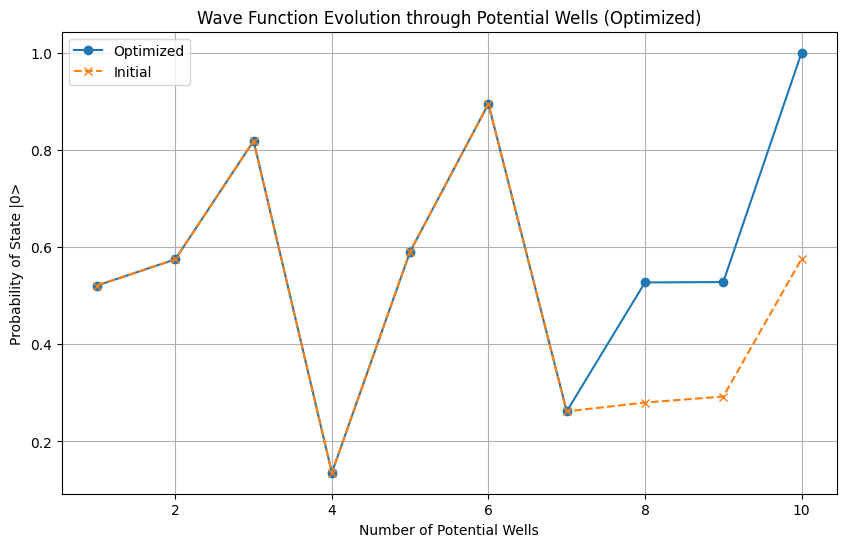

In [11]:
# Visualize cost convergence
visualize_cost_convergence(costs)


# Visualize optimized wave function evolution using stored optimized parameters
visualize_optimized_evolution(params_last_three, n_bins, quantum_circuit, probabilities)


## Understanding the Cost Function

The **cost function** in this simulation represents the negative of the probability of detecting the wave function in the desired quantum state $|0\rangle$ after it passes through all the potential wells. 

### Key Points:
- **Objective**: To maximize the probability of the wave function being in state $|0\rangle$. 
- **Cost Function Definition**: 
  $$
  \text{Cost} = - P(|0\rangle)
  $$
  where $P(|0\rangle)$ is the probability of measuring the qubit in state $|0\rangle$ at the end of the circuit.
- **Optimization Strategy**: By minimizing this cost function, we effectively maximize $P(|0\rangle)$. The negative sign allows us to use standard optimization algorithms that minimize a cost function.
- **Physical Interpretation**: This represents adjusting the last three potential wells' parameters to shape the wave function's evolution, maximizing the likelihood of detecting it in the desired state.

By visualizing the cost function's convergence over iterations, we can see how well the optimization is progressing toward maximizing the desired probability.
